# How to create Figure 4


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from difflikelihoods import odesolver
from difflikelihoods import linearised_odesolver as linsolver
from difflikelihoods import linearised_ode as linode
from difflikelihoods import statespace
from difflikelihoods import inverseproblem as ip
from difflikelihoods.optimisation import minimise_newton, minimise_gd, minimise_rs
from sampling_functions import *

At first we create the data, set the model parameters and the method parameters.

In [2]:
def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, 2, 0)
    evalpts = np.array([1., 2., 3., 4., 5.])
    evalpts = np.arange(.5, 5., 5/10)
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts)*2).reshape((len(evalpts), 2))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata

## Optimisation Experiments

We begin with the optimisation experiments. We begin by specifying the model and method parameters.

In [3]:
np.random.seed(2)

# Set Model Parameters
initial_value = np.array([20, 20])
initial_time, end_time = 0., 5.
ivpvar = 1e-10
thetatrue = np.array([1.0, 0.1, 0.1, 1.0])
ivp = linode.LotkaVolterra(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/100
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=2))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)

Next, we specify an initial value and compute the minisers for Newton, GD and RS as well as the respective root mean squared errors.

In [4]:
niter = 100
init_theta = np.array([.8, .2, .05, 1.1])

traj_newton, obj_newton = minimise_newton(iplklhd.potenteval, iplklhd.gradeval, iplklhd.hesseval, niter, init_theta, lrate=0.5)
error_newton = np.sqrt(np.sum(np.abs(traj_newton - thetatrue)**2/(thetatrue**2) ,axis=-1))

traj_gd, obj_gd = minimise_gd(iplklhd.potenteval, iplklhd.gradeval, niter, init_theta, lrate=1e-9)
error_gd = np.sqrt(np.sum(np.abs(traj_gd - thetatrue)**2/(thetatrue**2) ,axis=-1))

traj_rs, obj_rs = minimise_rs(iplklhd.potenteval, niter, init_theta, lrate=1e-2)
error_rs = np.sqrt(np.sum(np.abs(traj_rs - thetatrue)**2/(thetatrue**2) ,axis=-1))

In [5]:
print("Newton guess:", traj_newton[-1])
print("GD guess:", traj_gd[-1])
print("RS guess:", traj_rs[-1])
print("Truth:", thetatrue)
print("Init:", init_theta)

Newton guess: [0.99820812 0.09987944 0.10014667 1.00021196]
GD guess: [0.8066007  0.08847439 0.10674646 1.07936458]
RS guess: [0.81164084 0.0890851  0.10601322 1.11067376]
Truth: [1.  0.1 0.1 1. ]
Init: [0.8  0.2  0.05 1.1 ]


Finally, we can visualise the results using both the log-likelihood values and the error in the parameter space as metrics.

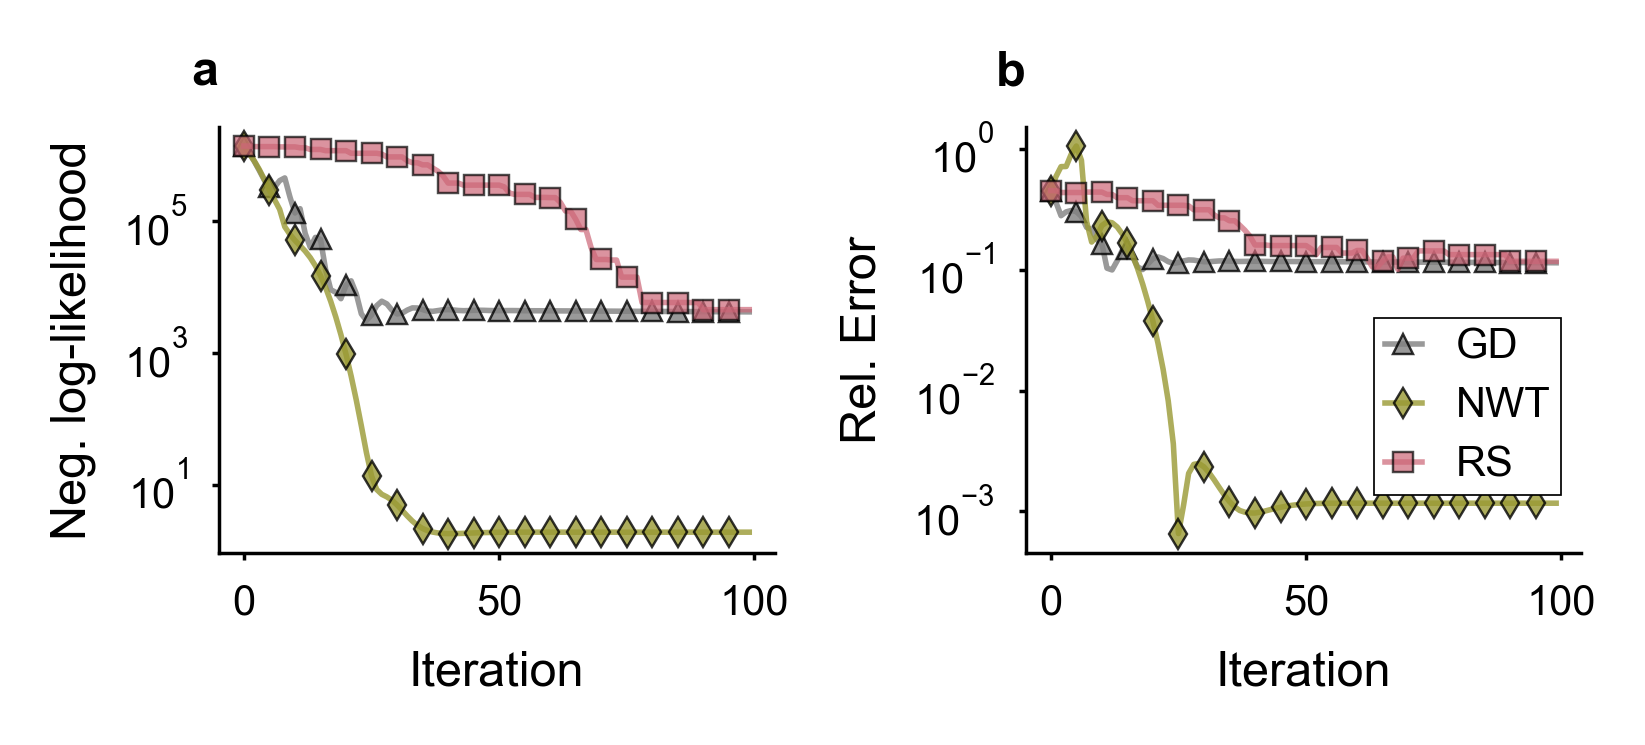

In [6]:
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
mark_every = 5
ax1.semilogy((obj_gd), markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax1.semilogy((obj_newton), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax1.semilogy((obj_rs), markevery=mark_every, color="#cc6677",   ls="-", marker="s", label="RS", alpha=0.7)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy(np.abs((traj_gd - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax2.semilogy(np.abs((traj_newton - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax2.semilogy(np.abs((traj_rs - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), markevery=mark_every, color="#cc6677",  ls="-", marker="s", label="RS", alpha=0.7)

ax1.set_title("a", loc="left", fontweight='bold', ha='right')
ax2.set_title("b", loc="left", fontweight='bold', ha='right')

ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6))
ax1.minorticks_off()
ax2.minorticks_off()

plt.tight_layout()
plt.savefig("./figures/figure4_optim_left.pdf")

plt.show()

## Sampling experiments

Next, we repeat the experiments with the sampling algorithms. We start with specifying the model and method parameters.

In [7]:
# Set Model Parameters
initial_value = np.array([20, 20])
initial_time, end_time = 0., 5.
ivpvar = 1e-2
thetatrue = np.array([1.0, 0.1, 0.1, 1.0])
ivp = linode.LotkaVolterra(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/400
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=2))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)

Next, we sample from the posteriors with Langevin MCMC, Hamiltonian MC and random walk Metropolis-Hastings.

In [8]:
niter = 250
init_theta = np.array([1, .2, .01, 1.1])
np.random.seed(1)
_ninits = 50
samples_lang, probs_lang = langevin(niter, iplklhd, init_theta, stepsize=1.15, ninits=45)
np.random.seed(1)
samples_ham, probs_ham = hamiltonian(niter, iplklhd, init_theta, stepsize=0.35, nsteps=3, ninits=45)
np.random.seed(1)
samples_rw, probs_rw = randomwalk(niter, iplklhd, init_theta, stepsize=0.0005, ninits=45)

Finally, we can visualise the results.

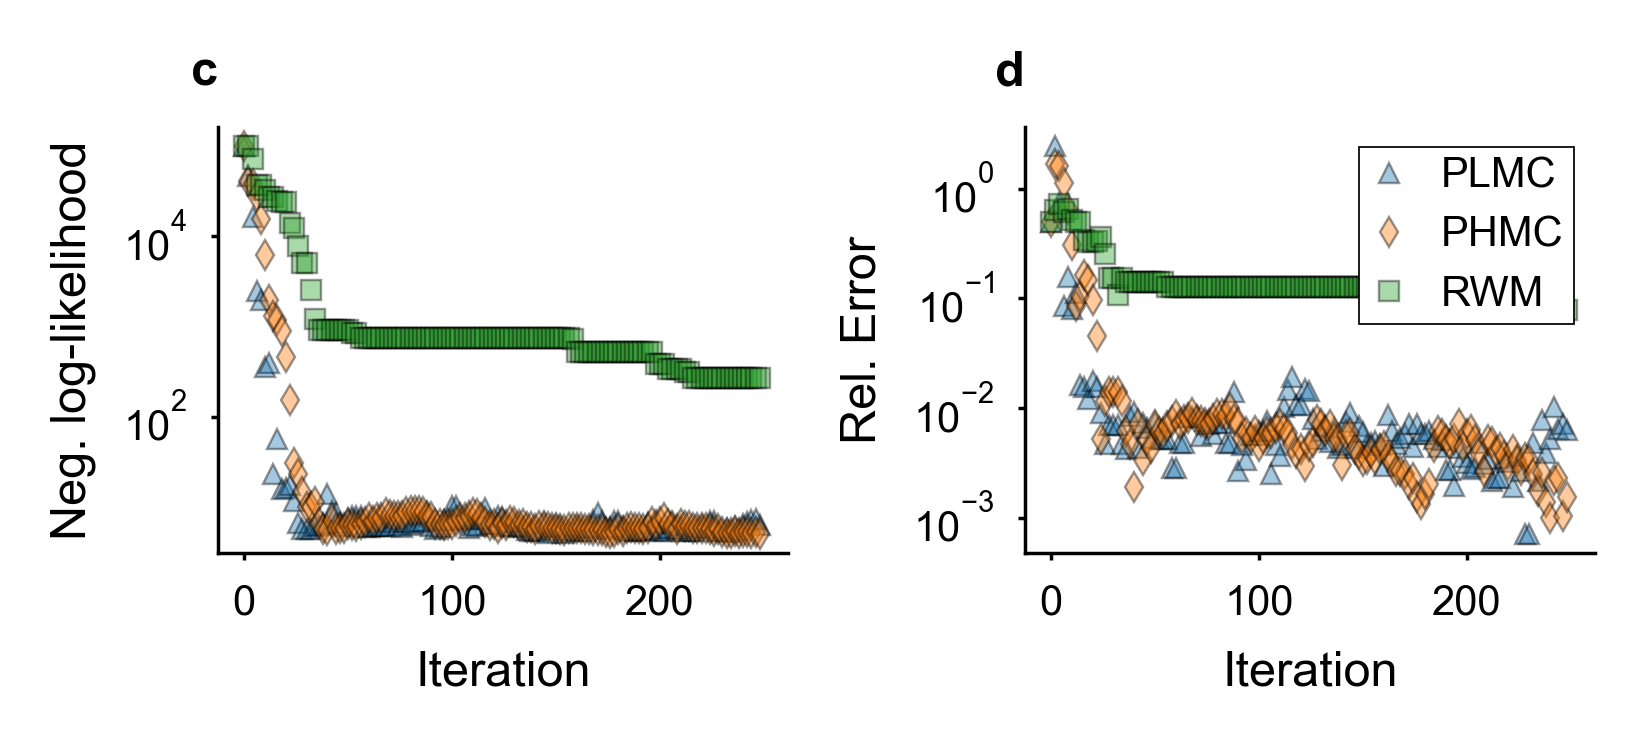

In [9]:
# Plot results
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
ax1.semilogy((probs_lang), ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_ham), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_rw), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy(np.abs((samples_lang - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_ham - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_rw - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)

ax1.set_title("c", loc="left", fontweight='bold', ha='right')
ax2.set_title("d", loc="left", fontweight='bold', ha='right')

ax2.legend()

ax1.minorticks_off()
ax2.minorticks_off()
plt.tight_layout()
plt.savefig("./figures/figure4_sampling_right.pdf")

plt.show()